## Independent Analysis - Srinivas (handle: thewickedaxe)
** PLEASE SCROLL TO THE BOTTOM OF THE NOTEBOOK TO FIND THE QUESTIONS AND THEIR ANSWERS**

### Initial Data Cleaning

In [3]:
# Standard
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dimensionality reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

# Plotting tools and classifiers
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut


# Let's read the data in and clean it

def row_summary(df):
    featNames = list(df.columns.get_values()) 
    row_summary = df.isnull().sum(axis=1)
    nan_row_inds = list()
    for i, x in enumerate(row_summary):
        if x > 0: nan_row_inds.append(i)
    return nan_row_inds

def clean_records(df):
    nan_row_inds = row_summary(df)
    clean_df = df.drop(df.index[nan_row_inds], inplace=False)     
    print 'Is there any NaNs in the clean records?', clean_df.isnull().values.any()    
    return clean_df

df = pd.DataFrame.from_csv('Data_Adults_1_reduced.csv')
clean_df = clean_records(df)

# Let's also get rid of nominal data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = clean_df.select_dtypes(include=numerics)
print X.shape

Is there any NaNs in the clean records? False
(3007, 624)


By throwing out GSC responses we salvaged around 200 records,
The rationale behind this I examined the GSC, BSC and LDS questions and realized most of what GSC looks at is and is relevant is caught in the other 2 surveys.

In [4]:
# Let's now clean columns getting rid of certain columns that might not be important to our analysis

cols2drop = ['GROUP_ID', 'doa', 'Baseline_header_id', 'Concentration_header_id',
             'Baseline_Reading_id', 'Concentration_Reading_id']
X = X.drop(cols2drop, axis=1, inplace=False)
print X.shape

# For our studies children skew the data, it would be cleaner to just analyse adults
X = X.loc[X['Age'] >= 18]

print X.shape

(3007, 618)
(2976, 618)


we've now dropped the last of the discrete numerical inexplicable data, and removed children from the mix

### Extracting the samples we are interested in

In [5]:
# Let's extract ADHd and Bipolar patients (mutually exclusive)

ADHD = X.loc[X['ADHD'] == 1]
ADHD = ADHD.loc[ADHD['Bipolar'] == 0]

BP = X.loc[X['Bipolar'] == 1]
BP = BP.loc[BP['ADHD'] == 0]

# Keeping a backup of the data frame object because numpy arrays don't play well with certain scikit functions
ADHD_df = ADHD
BP_df = BP
ADHD = ADHD.drop(['Patient_ID'], axis = 1, inplace = False)
BP = BP.drop(['Patient_ID'], axis = 1, inplace = False)

we see here that there 1110 people who have ADHD but are not Bipolar and 329 people who are Bipolar but do not have ADHD

### Dimensionality reduction

In [6]:
pca = PCA(n_components = 24, whiten = "True").fit(ADHD)
ADHD = pca.transform(ADHD)
print sum(pca.explained_variance_ratio_)

pca = PCA(n_components = 24, whiten = "True").fit(BP)
BP = pca.transform(BP)
print sum(pca.explained_variance_ratio_)

print ADHD.shape
print BP.shape

ADHD_reduced_df = pd.DataFrame(ADHD)

BP_reduced_df = pd.DataFrame(BP)

ADHD_reduced_df['Patient_ID'] = 123
BP_reduced_df['Patient_ID'] = 123

print ADHD_reduced_df.shape
print BP_reduced_df.shape

# resorting to some hacky crap, that I am ashamed to write, but pandas is refusing to cooperate
z = []
for x in BP_df['Patient_ID']:
    z.append(x)
BP_reduced_df['Patient_ID'] = z

z = []
for x in ADHD_df['Patient_ID']:
    z.append(x)
ADHD_reduced_df['Patient_ID'] = z

0.947804202921
0.945813229464
(1101, 24)
(329, 24)
(1101, 25)
(329, 25)


We see here that most of the variance is preserved with just 24 features. 

### Clustering and other grouping experiments

#### Mean-Shift

In [7]:
ADHD_clust = pd.DataFrame(ADHD)
BP_clust = pd.DataFrame(BP)

# This is a consequence of how we dropped columns, I apologize for the hacky code 
data = pd.concat([ADHD_clust, BP_clust])

# Let's see what happens with Mean Shift clustering
bandwidth = estimate_bandwidth(data.get_values(), quantile=0.9, n_samples=1430) * 1.1
ms = MeanShift(bandwidth=bandwidth)
ms.fit(data.get_values())
labels = ms.labels_

In [8]:
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


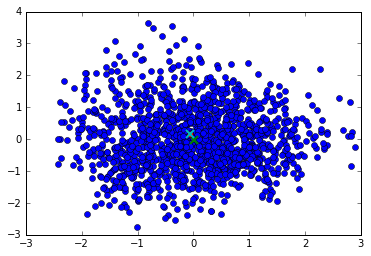

In [9]:
for i in range(n_clusters_):
    # Extract observations within each cluster
    ds = data.get_values()[np.where(labels==i)]
    # Plot the observations with symbol o
    plt.plot(ds[:,0], ds[:,1], 'o')
    # Plot the centroids with simbol x
    lines = plt.plot(cluster_centers[i,0], cluster_centers[i,1], 'x')
    plt.setp(lines, ms=8.0)
    plt.setp(lines, mew=2.0)

Though I'm not sure how to tweak the hyper-parameters of the bandwidth estimation function, there doesn't seem to be much difference. Minute variations to the bandwidth result in large cluster differences. Perhaps the data isn't very suitable for a contrived clustering technique like Mean-Shift. Therefore let us attempt something more naive and simplistic like K-Means

#### K-Means clustering

In [10]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data.get_values())
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(centroids))
print data.shape

Estimated number of clusters: 2
(1430, 24)


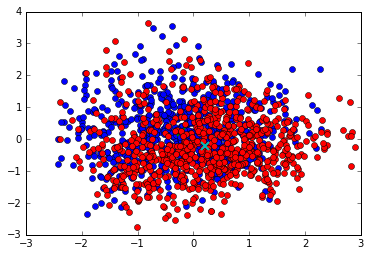

In [11]:
for i in range(2):
    # Extract observations within each cluster
    ds = data.get_values()[np.where(labels==i)]
    # Plot the observations with symbol o
    plt.plot(ds[:,0], ds[:,1], 'o')
    # Plot the centroids with simbol x
    lines = plt.plot(centroids[i,0], centroids[i,1], 'x')
    plt.setp(lines, ms=8.0)
    plt.setp(lines, mew=2.0)

As is evident from the above 2 experiments, no clear clustering is apparent.But there is some significant overlap and there 2 clear groups

### Classification Experiments

Let's experiment with a bunch of classifiers

In [12]:
# support methods
# Train the given classifier
def train_clf(clf, train_feats, train_labels):
    # Supervised training
    clf.fit(train_feats, train_labels)
    
# Test the given classifier anc calculate accuracy
def test_clf(clf, test_feats, test_labels):
    # Predict using test set
    predicted = clf.predict(test_feats)
    # Compute accuracy
    acc = np.mean(predicted == test_labels)
    return predicted, acc

# Compute accuracy of a model trained with a specific number (n) of samples 
def compute_acc(clf, n):
    train_clf(clf, train_X[:n], train_y[:n])
    predict_y, acc = test_clf(clf, test_X, test_y)
    return acc

# Leave one out cross validation
def loo_cv(clf, X, y):
    loo = LeaveOneOut(len(X))
    scores = cross_validation.cross_val_score(clf, X, y, cv=loo)
    return scores.mean(), scores.std()

In [14]:
BP_reduced_df['ADHD-Bipolar'] = 0
ADHD_reduced_df['ADHD-Bipolar'] = 1

data = pd.concat([ADHD_reduced_df, BP_reduced_df])
class_labels = data['ADHD-Bipolar']
data = data.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
print data.shape
data = data.get_values()

(1430, 25)


In [15]:
# Logistic Regression
lg = LogisticRegression(penalty='l2')
acc_lg, acc_std_lg = loo_cv(lg, data, class_labels)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=7)
acc_knn, acc_std_knn = loo_cv(knn, data, class_labels)

# Support Vector Machine
svc = SVC(gamma=2, C=1)
acc_svm, acc_std_svm = loo_cv(svc, data, class_labels)

# Random Forest
rf = RandomForestClassifier(n_estimators=20) 
acc_rf, acc_std_rf = loo_cv(rf, data, class_labels)

# Random Forest
dt = DecisionTreeClassifier(max_depth = 20) 
acc_dt, acc_std_dt = loo_cv(dt, data, class_labels)

# Quadratic Discriminant Analysis
qda = QDA()
acc_qda, acc_std_qda = loo_cv(qda, data, class_labels)

# Gaussian Naive Bayes
gnb = GaussianNB()
acc_gnb, acc_std_gnb = loo_cv(gnb, data, class_labels)

In [16]:
print 'Logistic Regression accuracy is %0.4f (+/- %0.3f)' % (acc_lg, acc_std_lg)
print 'K Nearest Neighbors accuracy is %0.4f (+/- %0.3f)' % (acc_knn, acc_std_knn)
print 'Support Vector Machine accuracy is %0.4f (+/- %0.3f)' % (acc_svm, acc_std_svm)
print 'Random Forest accuracy is %0.4f (+/- %0.3f)' % (acc_rf, acc_std_rf)
print 'Decision tree accuracy is %0.4f (+/- %0.3f)' % (acc_dt, acc_std_dt)
print 'Quadratic Discriminant Analysis accuracy is %0.4f (+/- %0.3f)' % (acc_qda, acc_std_qda)
print 'Gaussian NB accuracy is %0.4f (+/- %0.3f)' % (acc_gnb, acc_std_gnb)

Logistic Regression accuracy is 0.7699 (+/- 0.421)
K Nearest Neighbors accuracy is 0.7364 (+/- 0.441)
Support Vector Machine accuracy is 0.7699 (+/- 0.421)
Random Forest accuracy is 0.7559 (+/- 0.430)
Decision tree accuracy is 0.6531 (+/- 0.476)
Quadratic Discriminant Analysis accuracy is 0.7119 (+/- 0.453)
Gaussian NB accuracy is 0.7699 (+/- 0.421)


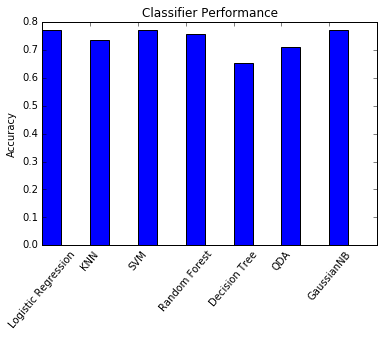

In [18]:
from __future__ import division

# Visualize classifier performance
acc = [acc_lg, acc_knn, acc_svm, acc_rf, acc_dt, acc_qda, acc_gnb]
clf_names = ['Logistic Regression', 'KNN', 'SVM', 'Random Forest', 'Decision Tree', \
             'QDA', 'GaussianNB']
x = range(len(acc))

width = 0.6/1.5
plt.bar(x, acc, width)

plt.title('Classifier Performance')
plt.xticks(x, clf_names, rotation=50)
plt.ylabel('Accuracy')

### Questions and Answers

Q1) *What preliminary manual cleaning did you carry out to reduce dimensionality and variance?*<br/>
A1) Examining the contents of the surveys I found that almost all the questions in GSC were captured in LDS and BSC, so I threw GSC out and reduced dimensionality by close to 100 features and salvaged 200 record from NaN rejection

Q2) *After dropping Nans and children how many actionable records do we have?*<br/>
A2) We have 2976 record

Q3) *What is the shape and size of the new sets of data we are interested in?*<br/>
A3) There are 1101 people who have ADHD but are not Bipolar and 329 people who are Bipolar but do not have ADHD

Q4) *What was the consequence of carrying out dimensionality reduction on them?*<br/>
A4) I experimented with regular PCA and SVD. SVD captured 81% of all the variance with just 3 features but did not capture significantly more by increasing feature count. PCA captured close to 95% of the variance with 24 features.

Q5) *Did you try mean-shift clustering on the data?*<br/>
A5) Yes, but it was inconclusive, data did not cluster well

Q6) *Did you try KMeans clustering on the data?*<br/>
A6) This was incconclusive as well, the data will have to be subject to other supervised learning techniques

Q7) through Q)13 *Did you attempt a cross validated train test with a classifier? what were the results?*<br/>
A7) through A)13<br/>
**Logistic Regression accuracy is 0.7699 (+/- 0.421)<br/>
K Nearest Neighbors accuracy is 0.7364 (+/- 0.441)<br/>
Support Vector Machine accuracy is 0.7699 (+/- 0.421)<br/>
Random Forest accuracy is 0.7559 (+/- 0.430)<br/>
Decision tree accuracy is 0.6531 (+/- 0.476)<br/>
Quadratic Discriminant Analysis accuracy is 0.7119 (+/- 0.453)<br/>
Gaussian NB accuracy is 0.7699 (+/- 0.421)<br/>**